# Super resolution 


## Loading PascalVOC2011 dataset

In [1]:
import os
def encode_labels(target):
    k = np.zeros((10))
    return k

In [2]:
### Enter you code here
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import time
import copy
import torchvision as tv
# ! pip install lmdb

means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

transform_train = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Resize((240,240)),
    transforms.Normalize(means, stds)
    ])

transform_val = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Resize((240,240)),
    transforms.Normalize(means, stds)
    ])

batch_size = 16
image_train = torchvision.datasets.VOCDetection(root='./data',year='2011',image_set='train',download = True, transform=transform_train,target_transform=encode_labels)
image_val = torchvision.datasets.VOCDetection(root='./data',year='2011',image_set='val',download = True, transform=transform_val,target_transform=encode_labels)

image_train_sub = torch.utils.data.Subset(image_train, list(range(0, 1000)))
image_val_sub = torch.utils.data.Subset(image_val, list(range(0, 200)))

dataloaders = {
    'train': DataLoader(image_train_sub, batch_size=batch_size,
                                             shuffle=True, num_workers=2),
    'val': DataLoader(image_val_sub, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  }

dataset_sizes={'train': 1000, 'val': 200}

  0%|          | 0/1765686784 [00:00<?, ?it/s]

Extracting ./data/VOCtrainval_25-May-2011.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_25-May-2011.tar
Extracting ./data/VOCtrainval_25-May-2011.tar to ./data


In [3]:
# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Visualize some of the training images

In this dataset the images have different sizes. Hence, we should verify that we resized them in the data-loader.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
def imshow(inp, title=None):
    # """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = inp*stds + means
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated


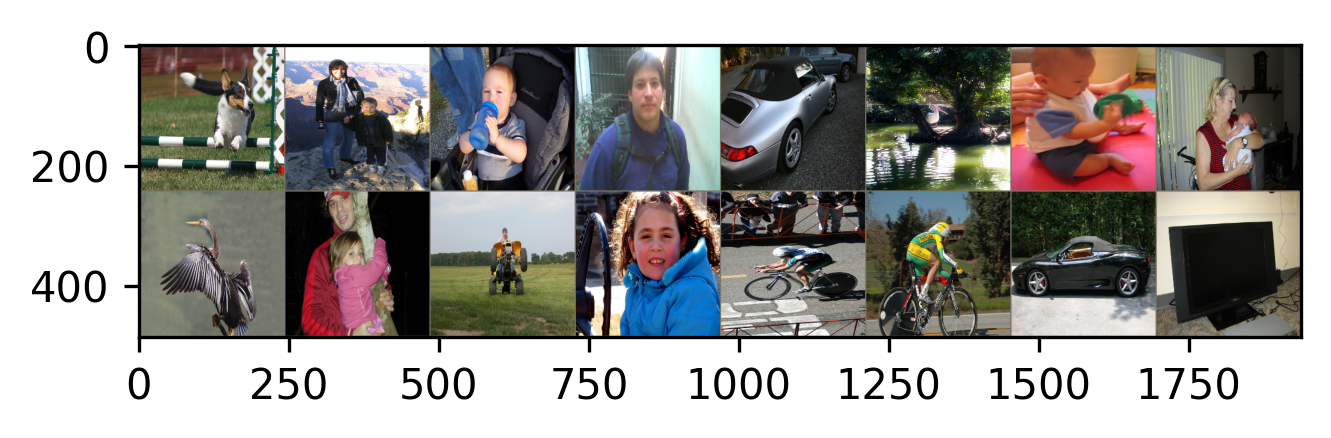

In [5]:
# # Make a grid from batch
img,_ = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(img, nrow=8)
imshow(out)


## Fully convolutional Neural Network

In [6]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self, num_channels=3):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=9 // 2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [7]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)


In [8]:
#!pip install torchsummary 
from torchsummary import summary
summary(model.to(device), (3, 240, 240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 240]          15,616
              ReLU-2         [-1, 64, 240, 240]               0
            Conv2d-3         [-1, 32, 240, 240]          51,232
              ReLU-4         [-1, 32, 240, 240]               0
            Conv2d-5          [-1, 3, 240, 240]           2,403
Total params: 69,251
Trainable params: 69,251
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.66
Forward/backward pass size (MB): 85.69
Params size (MB): 0.26
Estimated Total Size (MB): 86.62
----------------------------------------------------------------


## Training 

### MSE loss

In [9]:
# If a GPU is available, make the model use it
model = model.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.MSELoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
# optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
### SCHOOL SOLUTION
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=1)

num_epochs = 10

In [10]:
# import torch.nn.functional as F
# import torchvision.models as models
import torchvision.transforms.functional as TF

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100.0
    #School solution
    train_res= np.zeros((num_epochs))
    val_res=np.zeros((num_epochs))
    dict_res={'train':train_res, 'val':val_res}
    #School solution

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        # for phase in ['train', 'val']:
        for phase in ['train','val']:
            num = 0
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            # Iterate over data
            for gt, _ in dataloaders[phase]:
            # for inputs, gt in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                gt = gt.to(device)
                inputs = TF.resize(gt,(120,120))
                inputs = TF.resize(inputs,(240,240))
                # zero the parameter gradients
                optimizer.zero_grad()
                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. 

                    MSE_loss = criterion(outputs, gt)
                    loss = MSE_loss

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer
                    num += 1

                running_loss += loss.item()# * inputs.size(0)

            # epoch_loss = running_loss / num #/ dataset_sizes[phase]
            epoch_loss = running_loss / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f}')

            dict_res[phase][epoch]=epoch_loss

            # Keep the results of the best model so far
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                # deepcopy the epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_loss:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, dict_res, MSE_loss

In [11]:
model,dict_res, MSE_loss = train_model(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=10)


Epoch 0/9
----------
train Loss: 0.0122
val Loss: 0.0058

Epoch 1/9
----------
train Loss: 0.0052
val Loss: 0.0044

Epoch 2/9
----------
train Loss: 0.0049
val Loss: 0.0041

Epoch 3/9
----------
train Loss: 0.0040
val Loss: 0.0036

Epoch 4/9
----------
train Loss: 0.0038
val Loss: 0.0035

Epoch 5/9
----------
train Loss: 0.0036
val Loss: 0.0033

Epoch 6/9
----------
train Loss: 0.0035
val Loss: 0.0032

Epoch 7/9
----------
train Loss: 0.0035
val Loss: 0.0033

Epoch 8/9
----------
train Loss: 0.0034
val Loss: 0.0031

Epoch 9/9
----------
train Loss: 0.0033
val Loss: 0.0030

Training complete in 1m 53s
Best val Acc: 0.003020


In [12]:
def plot_convergence(dict_res, num_epochs):
  types=['Loss']
  plt.plot(dict_res['train']); plt.plot(dict_res['val']); plt.title('Loss'); plt.legend(['train','val'])


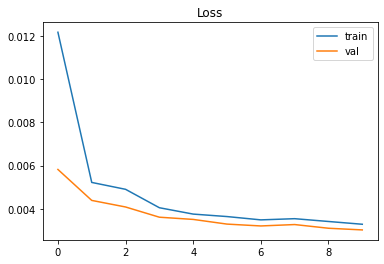

In [13]:
plot_convergence(dict_res,num_epochs ); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


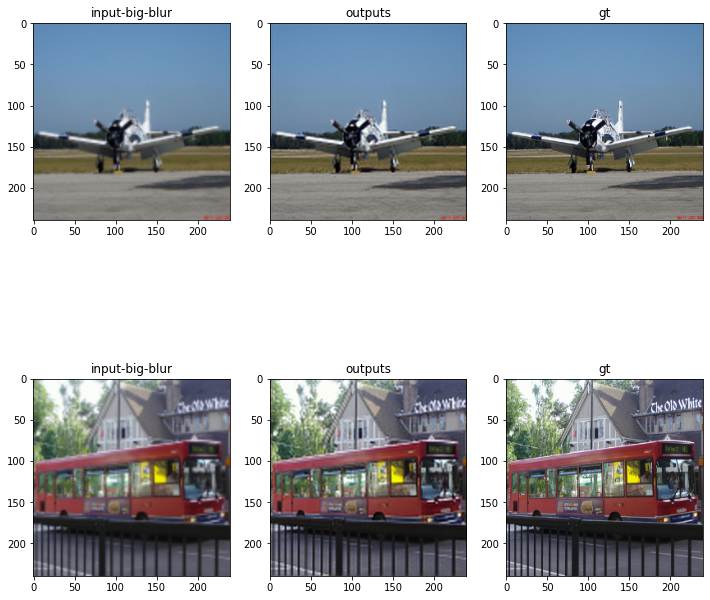

In [32]:
#MSE
gt, _ = next(iter(dataloaders['val']))
gt = gt.to(device)
inputs = TF.resize(gt,(120,120))
inputs = TF.resize(inputs,(240,240))
inputs = inputs.to(inputs)

outputs = model(inputs)
outputs = outputs.cpu().detach().numpy().transpose(0,2,3,1)
inputs = inputs.cpu().detach().numpy().transpose(0,2,3,1)
gt = gt.cpu().detach().numpy().transpose(0,2,3,1)

for i in range(0,gt.shape[0]):
  outputs[i,:,:,:] =  outputs[i,:,:,:]*stds+means
  inputs[i,:,:,:] =  inputs[i,:,:,:]*stds+means
  gt[i,:,:,:] =  gt[i,:,:,:]*stds+means

plt.figure(figsize=(12,12))
image_1 = 5
image_2 = 8
plt.subplot(2,3,1); plt.imshow((inputs[image_1,:,:,:])); plt.title('input-big-blur')
plt.subplot(2,3,2); plt.imshow((outputs[image_1,:,:,:])); plt.title('outputs')
plt.subplot(2,3,3); plt.imshow((gt[image_1,:,:,:])); plt.title('gt')
plt.subplot(2,3,4); plt.imshow((inputs[image_2,:,:,:])); plt.title('input-big-blur')
plt.subplot(2,3,5); plt.imshow((outputs[image_2,:,:,:])); plt.title('outputs')
plt.subplot(2,3,6); plt.imshow((gt[image_2,:,:,:])); plt.title('gt')

plt.show()

### MSE and perceptual loss

In [70]:
model_perc = NeuralNetwork().to(device)
# If a GPU is available, make the model use it
model_perc = model_perc.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.MSELoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
# optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
### SCHOOL SOLUTION
optimizer_ft = optim.Adam(model_perc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=1)

num_epochs = 10

In [71]:
import torch
import torch.nn as nn
from torchvision.models import vgg16
from collections import namedtuple

class Vgg16(torch.nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        features = list(vgg16(pretrained = True).features)
        # features3，8，15，23: relu1_2,relu2_2,relu3_3,relu4_3
        self.features = nn.ModuleList(features).eval() 
        
    # def forward(self, x):
    #     results = []
    #     for ii,model in enumerate(self.features):
            # x = model(x)
            # if ii in {3,8,15,22}:
            #     results.append(x)

In [72]:
model_vgg = Vgg16()
model_vgg = model_vgg.to(device)
model_vgg.features.eval()
relu1_2 = nn.Sequential(*list(model_vgg.features)[:3])
relu2_2 = nn.Sequential(*list(model_vgg.features)[:8])
relu3_3 = nn.Sequential(*list(model_vgg.features)[:15])
relu4_3 = nn.Sequential(*list(model_vgg.features)[:23])

In [80]:
model_vgg

Vgg16(
  (features): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [73]:
relu4_3

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [74]:
# import torch.nn.functional as F
# import torchvision.models as models
import torchvision.transforms.functional as TF

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100.0
    #School solution
    train_res= np.zeros((num_epochs))
    val_res=np.zeros((num_epochs))
    dict_res={'train':train_res, 'val':val_res}
    #School solution

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        # for phase in ['train', 'val']:
        for phase in ['train','val']:
            num = 0
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_loss_MSE = 0.0
            running_loss_perc = 0.0
            # Iterate over data
            for gt, _ in dataloaders[phase]:
            # for inputs, gt in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                gt = gt.to(device)
                #prepare input image to be blurry 240x240
                inputs = TF.resize(gt,(120,120))
                inputs = TF.resize(inputs,(240,240))
                # get the activations of the ground-truth

                alpha = 0.01
                beta = 0.003
                gt_1 = relu1_2(gt)
                  gt_2 = relu2_2(gt)
                  gt_3 = relu3_3(gt)
                  gt_4 = relu4_3(gt)
                # zero the parameter gradients
                optimizer.zero_grad()
                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. 
                    # get the activations of the output


                    out_1 = relu1_2(outputs) 
                    out_2 = relu2_2(outputs)
                    out_3 = relu3_3(outputs)
                    out_4 = relu4_3(outputs)

                    MSE_loss = criterion(outputs, gt)
                    perc_loss = criterion(out_4,gt_4)+criterion(out_3,gt_3)+criterion(out_2,gt_2)+criterion(out_1,gt_1)
                    loss = MSE_loss+0.01*perc_loss

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer
                    num += 1

                running_loss += loss.item()# * inputs.size(0)
                running_loss_MSE += MSE_loss.item()
                running_loss_perc += 0.01*perc_loss.item()

            # epoch_loss = running_loss / num #/ dataset_sizes[phase]
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_loss_MSE = running_loss_MSE / dataset_sizes[phase]
            epoch_loss_perc = running_loss_perc / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f}')
            print(epoch_loss_MSE)
            print(epoch_loss_perc)
            dict_res[phase][epoch]=epoch_loss


            # Keep the results of the best model so far
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                # deepcopy the epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_loss:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, dict_res, MSE_loss

In [76]:
model_perc,dict_res_perc, inputs  = train_model(model_perc, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=10)


Epoch 0/9
----------
train Loss: 0.0399
0.004093964044004679
0.0035776356315612794
val Loss: 0.0345
0.0037155605107545855
0.003075981407165527

Epoch 1/9
----------
train Loss: 0.0340
0.0037413097359240057
0.0030222285995483394
val Loss: 0.0312
0.0036616264656186104
0.0027511565017700195

Epoch 2/9
----------
train Loss: 0.0315
0.003576004546135664
0.0027964156532287597
val Loss: 0.0289
0.003196988198906183
0.0025744795417785645

Epoch 3/9
----------
train Loss: 0.0301
0.003484433125704527
0.002662780652999877
val Loss: 0.0300
0.004462466146796942
0.002553750991821289

Epoch 4/9
----------
train Loss: 0.0294
0.00346057166159153
0.0025963628253936775
val Loss: 0.0270
0.003041939828544855
0.002400200099945068

Epoch 5/9
----------
train Loss: 0.0285
0.0032954387478530407
0.002522940216064453
val Loss: 0.0265
0.002973128408193588
0.0023560934448242183

Epoch 6/9
----------
train Loss: 0.0282
0.0033697414137423038
0.0024837070884704596
val Loss: 0.0265
0.0031492056138813494
0.0023329208183

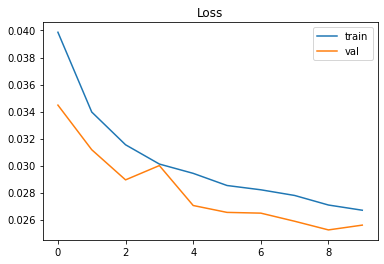

In [77]:
plot_convergence(dict_res_perc,num_epochs ); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


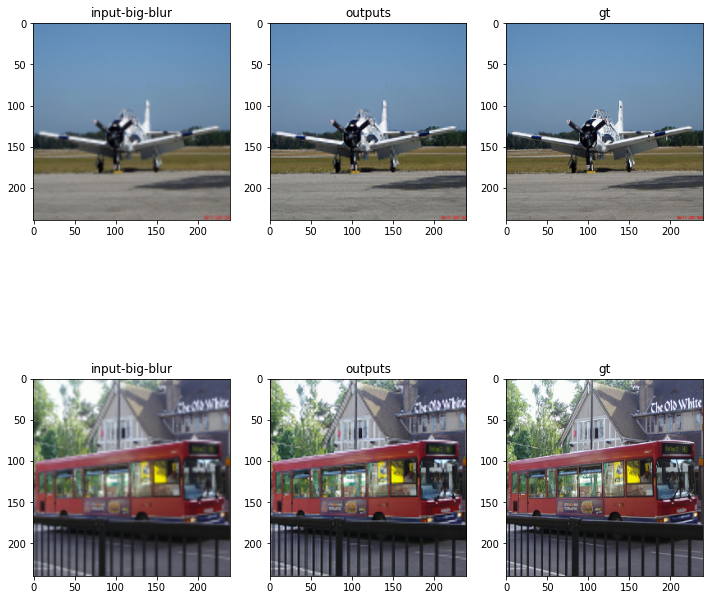

In [78]:
#MSE+perceptual loss
gt, _ = next(iter(dataloaders['val']))
gt = gt.to(device)
inputs = TF.resize(gt,(120,120))
inputs = TF.resize(inputs,(240,240))
inputs = inputs.to(inputs)

outputs = model_perc(inputs)
outputs = outputs.cpu().detach().numpy().transpose(0,2,3,1)
inputs = inputs.cpu().detach().numpy().transpose(0,2,3,1)
gt = gt.cpu().detach().numpy().transpose(0,2,3,1)

for i in range(0,gt.shape[0]):
  outputs[i,:,:,:] =  outputs[i,:,:,:]*stds+means
  inputs[i,:,:,:] =  inputs[i,:,:,:]*stds+means
  gt[i,:,:,:] =  gt[i,:,:,:]*stds+means

image_1 = 5
image_2 = 8
plt.figure(figsize=(12,12))
plt.subplot(2,3,1); plt.imshow((inputs[image_1,:,:,:])); plt.title('input-big-blur')
plt.subplot(2,3,2); plt.imshow((outputs[image_1,:,:,:])); plt.title('outputs')
plt.subplot(2,3,3); plt.imshow((gt[image_1,:,:,:])); plt.title('gt')
plt.subplot(2,3,4); plt.imshow((inputs[image_2,:,:,:])); plt.title('input-big-blur')
plt.subplot(2,3,5); plt.imshow((outputs[image_2,:,:,:])); plt.title('outputs')
plt.subplot(2,3,6); plt.imshow((gt[image_2,:,:,:])); plt.title('gt')

plt.show()

In [79]:
gt_MSE, _ = next(iter(dataloaders['val']))
gt_MSE = gt_MSE.to(device)
inputs_MSE = TF.resize(gt_MSE,(120,120))
inputs_MSE = TF.resize(inputs_MSE,(240,240))
inputs_MSE = inputs_MSE.to(inputs_MSE)

outputs_MSE = model(inputs_MSE)
outputs_MSE = outputs_MSE.cpu().detach().numpy().transpose(0,2,3,1)
inputs_MSE = inputs_MSE.cpu().detach().numpy().transpose(0,2,3,1)
gt_MSE = gt_MSE.cpu().detach().numpy().transpose(0,2,3,1)

for i in range(0,gt.shape[0]):
  outputs_MSE[i,:,:,:] =  outputs_MSE[i,:,:,:]*stds+means
  inputs_MSE[i,:,:,:] =  inputs_MSE[i,:,:,:]*stds+means
  gt_MSE[i,:,:,:] =  gt_MSE[i,:,:,:]*stds+means

plt.figure(figsize=(100,100))
image_1 = 5
image_2 = 8
plt.subplot(2,4,1); plt.imshow((inputs_MSE[image_1,:,:,:])); plt.title('input-big-blur')
plt.subplot(2,4,2); plt.imshow((outputs_MSE[image_1,:,:,:])); plt.title('outputs_MSE')
plt.subplot(2,4,3); plt.imshow((outputs[image_1,:,:,:])); plt.title('outputs_PERC')
plt.subplot(2,4,4); plt.imshow((gt_MSE[image_1,:,:,:])); plt.title('gt')
plt.subplot(2,4,5); plt.imshow((inputs_MSE[image_2,:,:,:])); plt.title('input-big-blur')
plt.subplot(2,4,6); plt.imshow((outputs_MSE[image_2,:,:,:])); plt.title('outputs_MSE')
plt.subplot(2,4,7); plt.imshow((outputs[image_2,:,:,:])); plt.title('outputs_PERC')
plt.subplot(2,4,8); plt.imshow((gt_MSE[image_2,:,:,:])); plt.title('gt')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
